In [2]:
import os
import re
import ants
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(seed=42) 

In [3]:
METADATADIR = os.path.join("/DATA", "ABCDFixRelease")
METADATADIRv4 = os.path.join("/DATA", "ABCD 4.0 Spreadsheets")
TASKDIR = "/DATA/ABCDTasks"

In [4]:
fs_qc_raw = pd.read_csv(f"{METADATADIR}/freesqc01.txt", sep="\t", skiprows=[1])
t2_qc = pd.read_csv(f"{METADATADIRv4}/abcd_t2wqc01.txt", sep="\t", skiprows=[1], usecols=["subjectkey", "t2w_postqc_qc"])
qc_raw = fs_qc_raw.merge(t2_qc, how="inner", on="subjectkey")
qc_raw.shape, qc_raw["subjectkey"].unique().shape

((18309, 23), (11238,))

In [5]:
t2_qc.t2w_postqc_qc.notna().sum(), t2_qc.query("t2w_postqc_qc != 0").t2w_postqc_qc.sum()

(541, 447.0)

In the t2w_postqc_qc 0 = reject ; 1 = accept according to https://nda.nih.gov/data_structure.html?short_name=abcd_t2wqc01

In [6]:
passed_all = qc_raw.query("eventname == 'baseline_year_1_arm_1' & \
                           fsqc_qc == 1 & fsqc_qu_pialover < 2 & fsqc_qu_wmunder < 2 & \
                           fsqc_qu_motion == 0 & fsqc_qu_artifact == 0 & t2w_postqc_qc != 0")
passed_all.shape

(7170, 23)

In [7]:
mri_raw = pd.read_csv(f"{METADATADIR}/abcd_mri01.txt", sep="\t", skiprows=[1])

final_qc = mri_raw[["subjectkey", "mri_info_deviceserialnumber"]].merge(passed_all, how="inner", on="subjectkey")
scanner_counts = final_qc["mri_info_deviceserialnumber"].value_counts()
scanner_qc = scanner_counts[scanner_counts > 20].index
final_qc = final_qc[final_qc["mri_info_deviceserialnumber"].isin(scanner_qc)]
final_qc.shape

(7166, 24)

## Save selected subject IDs

> **INTERSECT WITH SUBJECTS THAT WE ACTUALLY HAVE ON DISK!!!**

In [8]:
import glob
R = re.compile(r"Data\/sub-(.*)\/ses-")
clean = lambda x: x.strip().replace("_", "")
t1_paths = glob.glob("/DATA/ImageData/Data/*/ses-baselineYear1Arm1/anat/*T1w.nii.gz")
t2_paths = glob.glob("/DATA/ImageData/Data/*/ses-baselineYear1Arm1/anat/*T2w.nii.gz")

In [9]:
_fn = lambda x: R.search(x).group(1).replace("NDAR", "NDAR_")
t1_ids = set(map(_fn, t1_paths))
t2_ids = set(map(_fn, t2_paths))
subject_ids = t1_ids.intersection(t2_ids)

In [10]:
t1_paths[:3]

['/DATA/ImageData/Data/sub-NDARINVVM3WVMV7/ses-baselineYear1Arm1/anat/sub-NDARINVVM3WVMV7_ses-baselineYear1Arm1_run-01_T1w.nii.gz',
 '/DATA/ImageData/Data/sub-NDARINVCDNAUD1U/ses-baselineYear1Arm1/anat/sub-NDARINVCDNAUD1U_ses-baselineYear1Arm1_run-01_T1w.nii.gz',
 '/DATA/ImageData/Data/sub-NDARINV1ZZAPY9K/ses-baselineYear1Arm1/anat/sub-NDARINV1ZZAPY9K_ses-baselineYear1Arm1_run-01_T1w.nii.gz']

In [11]:
len(t1_ids), len(t2_ids), len(subject_ids)

(3881, 3790, 3788)

In [12]:
final_qc["subjectkey"].shape

(7166,)

In [13]:
final_qc_keys = final_qc["subjectkey"].drop_duplicates()
final_qc_keys.shape

(4601,)

In [14]:
on_disk = final_qc_keys.isin(subject_ids)
on_disk.shape

(4601,)

In [15]:
inlier_keys = final_qc_keys[on_disk]
inlier_keys.shape

(1371,)

In [16]:
VAL_RATIO = 0.1

val_size = int(VAL_RATIO * len(inlier_keys))

validation = inlier_keys[:val_size]
testing = inlier_keys[val_size:val_size*2]
training = inlier_keys[val_size*2:]

In [17]:
assert np.sum((training.shape, validation.shape, testing.shape)) == inlier_keys.shape[0]
training.shape, validation.shape, testing.shape

((1097,), (137,), (137,))

In [18]:
# training.to_csv("train_keys.txt", header=None, index=None)
# validation.to_csv("val_keys.txt", header=None, index=None)
# testing.to_csv("test_keys.txt", header=None, index=None)
# outlier_keys.to_csv("ood_keys.txt", header=None, index=None)

In [19]:
abcd_qc_passing_keys = pd.concat((training, validation, testing))
abcd_qc_passing_keys.shape

(1371,)

In [20]:
len(abcd_qc_passing_keys.unique())

1371

In [154]:
# abcd_qc_passing_keys.to_csv("abcd_qc_passing_keys.txt", header=None, index=None)

## After WM Segmentations

In [21]:
save_dir = "/DATA/Users/amahmood/braintyp/segs/"
seg_paths = glob.glob(f"{save_dir}/*.npz")

In [22]:
%%time
t1_wm = []
t2_wm = []

for p in seg_paths:
    with np.load(p) as f:
        t1_wm.append(f['t1'])
        t2_wm.append(f['t2'])

CPU times: user 27.9 s, sys: 2.55 s, total: 30.5 s
Wall time: 31.9 s


In [23]:
seg_paths[0]

'/DATA/Users/amahmood/braintyp/segs/NDARINV7ZE3WGCX.npz'

In [24]:
re.search(r"(NDAR.*).npz",seg_paths[0]).group(1)

'NDARINV7ZE3WGCX'

In [79]:
subids = [re.search(r"(NDAR.*).npz", p).group(1) for p in seg_paths]

In [27]:
assert len(subids) == len(abcd_qc_passing_keys)

In [26]:
t1_wm_means = pd.Series(np.array([x.mean() for x in t1_wm]), index=subids)
t2_wm_means = pd.Series(np.array([x.mean() for x in t2_wm]), index=subids)

In [80]:
t1_wm_stds = pd.Series(np.array([x.std() for x in t1_wm]), index=subids)
t2_wm_stds = pd.Series(np.array([x.std() for x in t2_wm]), index=subids)

count    1371.000000
mean        0.865099
std         0.042438
min         0.009469
25%         0.855540
50%         0.873478
75%         0.888241
max         0.939414
dtype: float64

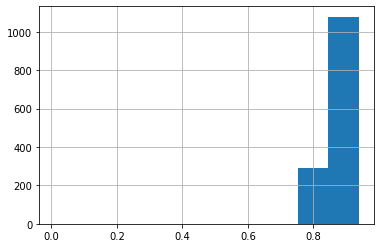

In [28]:
t1_wm_means.hist()
t1_wm_means.describe()

In [29]:
t1_wm_means.index[t1_wm_means.isna()]

Index([], dtype='object')

In [30]:
np.argwhere(t1_wm_means.isna().to_numpy())

array([], shape=(0, 1), dtype=int64)

In [88]:
means_mu = t1_wm_means.dropna().mean()
means_std = t1_wm_means.dropna().std()

print(f"Mean: {means_mu:.3f} w/ std {means_std:.3f}")

Mean: 0.865 w/ std 0.042


In [110]:
t1_candidates = (t1_wm_means > (means_mu + 3*means_std)) | (t1_wm_means < (means_mu - 3*means_std))
t1_outliers = list(np.argwhere(t1_candidates.to_numpy()).flatten())
t1_inliers = np.argwhere(~t1_candidates.to_numpy()).flatten()
len(t1_outliers) + len(t1_inliers)

1371

In [99]:
t1_wm_means[t1_outliers]

NDARINVV1F9DNZH    0.009469
dtype: float32

### T1 Standard Deviation distribution

count    1371.000000
mean        0.044052
std         0.008849
min         0.019418
25%         0.038065
50%         0.046700
75%         0.050825
max         0.061637
dtype: float64

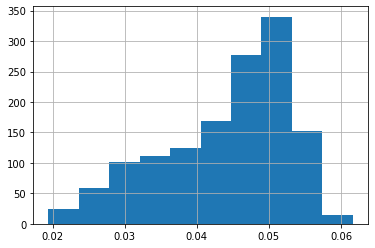

In [81]:
t1_wm_stds.hist()
t1_wm_stds.describe()

In [86]:
stds_mu = t1_wm_stds.mean()
stds_std = t1_wm_stds.std()

print(f"Mean: {stds_mu:.3f} w/ std {stds_std:.3f}")

Mean: 0.044 w/ std 0.009


In [111]:
t1_candidates = (t1_wm_stds > (stds_mu + 3*stds_std)) | (t1_wm_stds < (stds_mu - 3*stds_std))
t1_outliers.extend(list(np.argwhere(t1_candidates.to_numpy()).flatten()))

In [113]:
t1_wm_stds[t1_outliers]

NDARINVV1F9DNZH    0.028661
dtype: float32

In [35]:
for tidx in t1_outliers:
    sid = t1_wm_means.index[tidx]
    path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T1w.nii.gz"
    print(path.replace("/DATA/", "/BEE/Connectome/ABCD/"))

/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINVV1F9DNZH/ses-baselineYear1Arm1/anat/sub-NDARINVV1F9DNZH_ses-baselineYear1Arm1_run-01_T1w.nii.gz


NDARINVV1F9DNZH: /DATA/ImageData/Data/sub-NDARINVV1F9DNZH/ses-baselineYear1Arm1/anat/sub-NDARINVV1F9DNZH_ses-baselineYear1Arm1_run-01_T1w.nii.gz


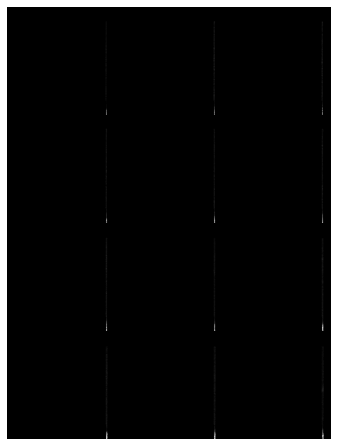

In [36]:
for tidx in t1_outliers:
    sid = t1_wm_means.index[tidx]
    path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T1w.nii.gz"
    print(f"{sid}: {path}")
    t1_outlier_img = ants.image_read(path)
    t1_outlier_img.plot()

### T2

count    1371.000000
mean        0.573386
std         0.032673
min         0.486719
25%         0.554836
50%         0.570660
75%         0.586823
max         0.817917
dtype: float64

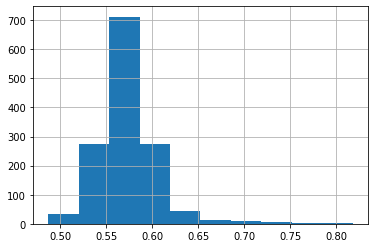

In [115]:
t2_wm_means.hist()
t2_wm_means.describe()

In [38]:
t2_mu = t2_wm_means.dropna().mean()
t2_std = t2_wm_means.dropna().std()

In [39]:
print(f"Mean: {t2_mu:.3f} w/ std {t2_std:.3f}")

Mean: 0.573 w/ std 0.033


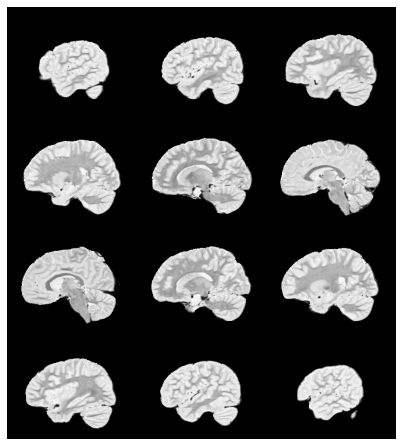

In [130]:
t2_median_idx = t2_wm_means.sort_values(ascending=False).index[len(t2_wm_means)//2]
path = f"/DATA/Users/amahmood/braintyp/processed_v2/{t2_median_idx}.nii.gz"
t2med_t1_img, t2_median_img = ants.image_read(path).split_channels()
t2_median_img.plot()

In [132]:
path

'/DATA/Users/amahmood/braintyp/processed_v2/NDARINVH5LXH4TB.nii.gz'

In [131]:
t2_viz_path =  f"/DATA/Users/amahmood/braintyp/t2_outliers/t2_{t2_median_idx}.nii.gz"
t2_median_img.to_filename(t2_viz_path)

In [160]:
t2_candidates = (t2_wm_means > (t2_mu + 4*t2_std)) | (t2_wm_means < (t2_mu - 4*t2_std))
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

14

In [161]:
t2_wm_means[t2_outliers].sort_values(ascending=False)

NDARINVGLRTPTNN    0.817917
NDARINVEPV33CZJ    0.795969
NDARINV6UU2L6YJ    0.786638
NDARINVP5DWFRD0    0.782934
NDARINVELUYAFWW    0.756556
NDARINV2LUG79YV    0.745846
NDARINVED4GJ51W    0.738232
NDARINVCTM83NPV    0.729256
NDARINVNXU172XX    0.719588
NDARINV3MLPX0CG    0.719051
NDARINV8GZUK8EV    0.715563
NDARINV8MRME9FG    0.712532
NDARINVA4MH2U9C    0.711713
NDARINV61X565FX    0.708416
dtype: float32

In [78]:
# ants.plot?

In [162]:
for sid in t2_wm_means[t2_outliers].sort_values(ascending=False).index:
    print(sid)
#     path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T2w.nii.gz"
#     t2_outlier_img = ants.image_read(path)
    path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
    t2out_t1_img, t2_outlier_img = ants.image_read(path).split_channels()
#     t2_outlier_img.plot()
    t2_viz_path =  f"/DATA/Users/amahmood/braintyp/t2_outliers/t2_{sid}.nii.gz"
    t2_outlier_img.to_filename(t2_viz_path)

NDARINVGLRTPTNN
NDARINVEPV33CZJ
NDARINV6UU2L6YJ
NDARINVP5DWFRD0
NDARINVELUYAFWW
NDARINV2LUG79YV
NDARINVED4GJ51W
NDARINVCTM83NPV
NDARINVNXU172XX
NDARINV3MLPX0CG
NDARINV8GZUK8EV
NDARINV8MRME9FG
NDARINVA4MH2U9C
NDARINV61X565FX


use mriwatcher on ondemand

In [187]:
print(path)

/DATA/Users/amahmood/braintyp/processed_v2/NDARINV8GZUK8EV.nii.gz


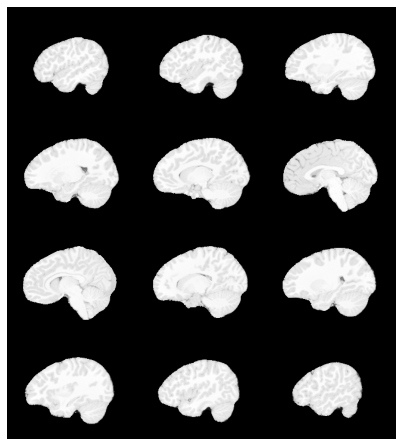

In [186]:
t2out_t1_img.plot()

In [46]:
os.symlink?

Signature: os.symlink(src, dst, target_is_directory=False, *, dir_fd=None)
Docstring:
Create a symbolic link pointing to src named dst.

target_is_directory is required on Windows if the target is to be
  interpreted as a directory.  (On Windows, symlink requires
  Windows 6.0 or greater, and raises a NotImplementedError otherwise.)
  target_is_directory is ignored on non-Windows platforms.

If dir_fd is not None, it should be a file descriptor open to a directory,
  and path should be relative; path will then be relative to that directory.
dir_fd may not be implemented on your platform.
  If it is unavailable, using it will raise a NotImplementedError.
Type:      builtin_function_or_method


In [71]:
link_dir =  f"/DATA/Users/amahmood/braintyp/t2_outliers/"
for l in glob.glob(f"{link_dir}/*"):
    os.unlink(l)

In [72]:
for sid in t2_wm_means[t2_outliers].sort_values(ascending=False).index:
    path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T2w.nii.gz"
#     path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
    true_path = path.replace("/DATA/", "/BEE/Connectome/ABCD/")
    link_path =  f"/DATA/Users/amahmood/braintyp/t2_outliers/{sid}.nii.gz"
    os.symlink(true_path, link_path)
    print(true_path)

/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINVGLRTPTNN/ses-baselineYear1Arm1/anat/sub-NDARINVGLRTPTNN_ses-baselineYear1Arm1_run-01_T2w.nii.gz
/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINVEPV33CZJ/ses-baselineYear1Arm1/anat/sub-NDARINVEPV33CZJ_ses-baselineYear1Arm1_run-01_T2w.nii.gz
/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINV6UU2L6YJ/ses-baselineYear1Arm1/anat/sub-NDARINV6UU2L6YJ_ses-baselineYear1Arm1_run-01_T2w.nii.gz
/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINVP5DWFRD0/ses-baselineYear1Arm1/anat/sub-NDARINVP5DWFRD0_ses-baselineYear1Arm1_run-01_T2w.nii.gz
/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINVELUYAFWW/ses-baselineYear1Arm1/anat/sub-NDARINVELUYAFWW_ses-baselineYear1Arm1_run-01_T2w.nii.gz
/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINV2LUG79YV/ses-baselineYear1Arm1/anat/sub-NDARINV2LUG79YV_ses-baselineYear1Arm1_run-01_T2w.nii.gz
/BEE/Connectome/ABCD/ImageData/Data/sub-NDARINVED4GJ51W/ses-baselineYear1Arm1/anat/sub-NDARINVED4GJ51W_ses-baselineYear1Arm1_run-01_T2w.nii.gz

### T2 Stds

count    1371.000000
mean        0.057056
std         0.013033
min         0.021600
25%         0.046202
50%         0.058556
75%         0.067649
max         0.133876
dtype: float64

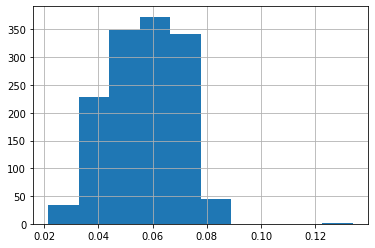

In [117]:
t2_wm_stds.hist()
t2_wm_stds.describe()

In [118]:
t2_stds_mu = t2_wm_stds.mean()
t2_stds_std = t2_wm_stds.std()

print(f"Mean: {t2_stds_mu:.3f} w/ std {t2_stds_std:.3f}")

Mean: 0.057 w/ std 0.013


In [120]:
t2_candidates = (t2_wm_stds > (t2_stds_mu + 3*t2_stds_std)) | (t2_wm_stds < (t2_stds_mu - 3*t2_stds_std))
t2_outliers = np.argwhere(t2_candidates.to_numpy()).flatten()
len(t2_outliers)

1

In [121]:
t2_wm_means[t2_outliers].sort_values(ascending=False)

NDARINVV1F9DNZH    0.57006
dtype: float32

In [78]:
# ants.plot?

In [122]:
for sid in t2_wm_means[t2_outliers].sort_values(ascending=False).index:
    print(sid)
#     path = f"/DATA/ImageData/Data/sub-{sid}/ses-baselineYear1Arm1/anat/sub-{sid}_ses-baselineYear1Arm1_run-01_T2w.nii.gz"
#     t2_outlier_img = ants.image_read(path)
    path = f"/DATA/Users/amahmood/braintyp/processed_v2/{sid}.nii.gz"
    t2out_t1_img, t2_outlier_img = ants.image_read(path).split_channels()
#     t2_outlier_img.plot()
    t2_viz_path =  f"/DATA/Users/amahmood/braintyp/t2_outliers/t2_{sid}.nii.gz"
    t2_outlier_img.to_filename(t2_viz_path)

NDARINVV1F9DNZH


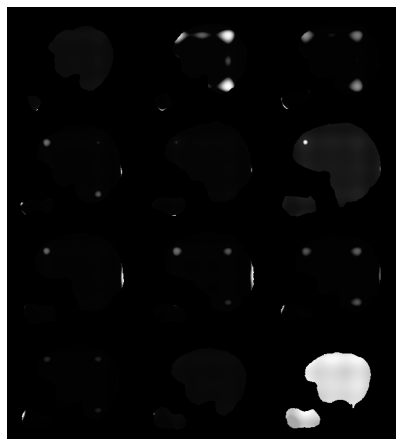

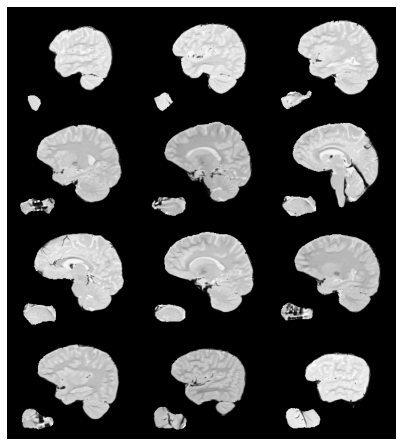

In [123]:
t2out_t1_img.plot()
t2_outlier_img.plot()

# Final set of cleaned keys!

In [149]:
abcd_qc_passing_keys[abcd_qc_passing_keys.eq("NDAR_INVV1F9DNZH")]

708    NDAR_INVV1F9DNZH
Name: subjectkey, dtype: object

> ## TODO: Add t2 outliers to list

In [154]:
wm_outlier_keys = set(x.replace("NDAR", "NDAR_") for x in t1_wm_means[t1_outliers].index)

In [153]:
abcd_wm_qc_passing_keys = abcd_qc_passing_keys.drop(
    abcd_qc_passing_keys[abcd_qc_passing_keys.eq("NDAR_INVV1F9DNZH")].index
)

In [156]:
abcd_wm_qc_passing_keys = abcd_qc_passing_keys[~abcd_qc_passing_keys.isin(wm_outlier_keys)]
abcd_wm_qc_passing_keys.shape

(1370,)

In [157]:
VAL_RATIO = 0.1

val_size = int(VAL_RATIO * len(abcd_wm_qc_passing_keys))

validation = abcd_wm_qc_passing_keys[:val_size]
testing = abcd_wm_qc_passing_keys[val_size:val_size*2]
training = abcd_wm_qc_passing_keys[val_size*2:]

In [158]:
assert np.sum((training.shape, validation.shape, testing.shape)) == abcd_wm_qc_passing_keys.shape[0]
training.shape, validation.shape, testing.shape

((1096,), (137,), (137,))

In [159]:
# training.to_csv("train_keys.txt", header=None, index=None)
# validation.to_csv("val_keys.txt", header=None, index=None)
# testing.to_csv("test_keys.txt", header=None, index=None)